# User Interface Concept for 2d Image Registration & Combination 

Created March 2018

This is an example user workflow using a hypothetical set of NIRCam images - 2 dithers from one filter, and 1 in some other filter.

##  Preliminaries

This illustrates the simplest possible workflow for *getting* the images.  The imagined `jwsttools` does not exist at the time of writing, so an alternate loading path is also demonstrated.

In [ ]:
#NEEDS IMPLEMENTING

import jwsttools

program_exposures = jwsttools.download_program(pid=1234)

(Assuming here that the only exposures in this program are the three outlined above.)

In [ ]:
filter1 = []
filter2 = []

for exp in program_exposures:
    if exp.filter == 'filter1':
        filter1.append(exp)
    elif exp.filter == 'filter2':
        filter2.append(exp)

### Alternate non-jwsttools path

1. User goes to web site, searches for their program ID
2. User downloads the specific files and saves them as "filter1_1.fits", "filter1_2.fits", "filter2_1.fits"

In [ ]:
from astropy import nddata

img1_1 = nddata.CCDData.read('filter1_1.fits')
img1_2 = nddata.CCDData.read('filter1_2.fits')
img2_1 = nddata.CCDData.read('filter2_1.fits')

filter1 = [img1_1, img1_2]
filter2 = [img2_1]

## Registration 

There should be "quick" tools for a user to check registration, assuming the WCS in the images is right.  Something like this:

In [ ]:
#NEEDS IMPLEMENTING

from someplace import show_image_sets #exactly what package this belongs in is a question...

This function will use the `.wcs` in the `img1_1` objects (which should be CCDData or maybe the jwst image object which is an NDData subclass).  It should assume the "new WCS API" which is currently being implemented.

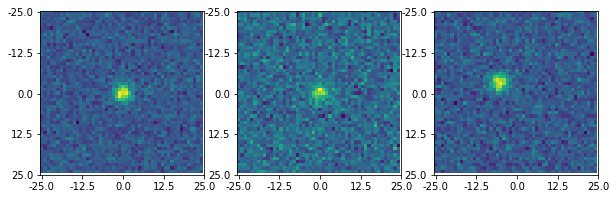

In [53]:
from astropy.coordinates import SkyCoord
coord = SkyCoord(<something>*u.deg, <something>*u.deg)  # this is some star the user sees is there

show_image_sets(coord, [img1_1, img1_2, img2_1], size=50)

At a minimum the user should see the above.  Bonus: an interactive set of ginga windows that zoom and move around in lock-step.

This inspection reveals the registration is off for the filter2 image.  Looks like the gwcs will need to be adjusted.

In [ ]:
import photutils

In [ ]:
srces = photutils.detect...(img1_1, ...choices...)  # this is an astropy.table !
srces_coords = ing1_1.wcs.pixel_to_world(srces['x'], srces['y'])

srces2 = photutils.detect...(img2_1, ...choices...)
#srces, srces2 can come from anywhere

# the would probably be a triangle-matching algorithm a la daomaster
idx1, idx2 = photutils.match_stars(srces, srces2) #NEEDS IMPLEMENTING (code may already be in pipeline)

# the below could be some random user thingie that they adjust for their own personal purpose
# below uses gwcs, not WCS APE API
newwcs = tweak_wcs(srces_coords[idx1], srces2[idx2], img2_1)   #NEEDS IMPLEMENTING (already in pipeline)

img2_1.wcs = newwcs  # (will this work in the JWST pipeline? that is, does *setting* wcs work?)

Should also have the above be available as:

In [ ]:
img2_1 = align_image(img1_1, img2_1)  # photutils  #NEEDS IMPLEMENTING?

# Combination

The assumption is that the WCS are now correct based on the above.  So now we "just" need to align the images to match.

In [ ]:
import reproject

Lets assume the user really just wants to align them to the "master" frame of image1_1.  Then just:

In [ ]:
# NEEDS IMPLEMENTING
# this function should drizzle uncertainties in a ~ reasonable way assuming uncorrelated

img1_2_matched = reproject.reproject_drizzle(img1_2, img1_1.header, ... any drizzle parameters here...)
img2_1_matched = reproject.reproject_drizzle(img2_1, img1_1.header, ... any drizzle parameters here...)

This makes combination conceptually-trivial:

In [ ]:
newimg = img1_1
for toadd in [img1_2_matched, img2_1_matched]:
    newimg = img1_1.add(toadd, propagate_uncertainties=True)  #requires that drizzle propogate uncertainties

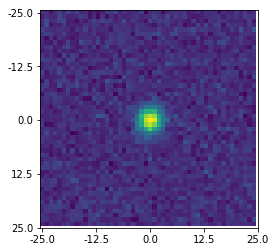

In [55]:
cutout = nddatautils.cutout_2d(newimg, coord, size=50)  #there is an nddata function that does this, but I forget the name
plt.imshow(cutout)

TOADD: Utility/documentation:
* The difference images of the above from each input

## Important   functionality note demoed here

* Background subtraction/measurement (this one is implied in the above - debatably this should be done as a separate step using the photutils background subtraction tools)
* Image model building/stats on the stack (NEEDS IMPLEMENTING)
* Outlier detection (this is not - NEEDS IMPLEMENTING)
* Support for mosaiced images (NEEDS IMPLEMENTING, although initial work already underway in reproject)

# Miscellaneous stuff (not part of the interface document)

Below here is code to "fake" the plots above, etc.  Not a part of the actual document.

In [ ]:
import numpy as np
from astropy.table import Table
from photutils import datasets

%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
t = Table()
t['amplitude'] = [10.]
t['x_mean'] = [25.]
t['y_mean'] = [25.]
t['x_stddev'] = [2.]
t['y_stddev'] = [2.]
t['theta'] = [0.]

gaussimg = datasets.make_gaussian_sources_image((50, 50), t)
img1 = datasets.make_noise_image((50, 50), mean=0, stddev=1) + gaussimg
img2 = datasets.make_noise_image((50, 50), mean=0, stddev=2) + gaussimg

t['x_mean'] = 19.5
t['y_mean'] = 21.7
gaussimg3 = datasets.make_gaussian_sources_image((50, 50), t)
img3 = datasets.make_noise_image((50, 50), mean=0, stddev=1.2) + gaussimg3

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)

for ax in [ax1, ax2, ax3]:
    tks = np.linspace(0, 50, 5)
    ax.set_xticks(tks)
    ax.set_xticklabels(tks - 25)
    ax.set_yticks(tks)
    ax.set_yticklabels(tks - 25)

In [ ]:
t = Table()
t['amplitude'] = [10.]
t['x_mean'] = [25.]
t['y_mean'] = [25.]
t['x_stddev'] = [2.]
t['y_stddev'] = [2.]
t['theta'] = [0.]

gaussimg = datasets.make_gaussian_sources_image((50, 50), t)
img1 = datasets.make_noise_image((50, 50), mean=0, stddev=.5) + gaussimg


fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
ax1.imshow(img1)

for ax in [ax1]:
    tks = np.linspace(0, 50, 5)
    ax.set_xticks(tks)
    ax.set_xticklabels(tks - 25)
    ax.set_yticks(tks)
    ax.set_yticklabels(tks - 25)